# SpotiPy Connect & Web Scraping
I want to find out who I listen to and what their basic background is.
[Medium Article](https://medium.com/@RareLoot/extracting-spotify-data-on-your-favourite-artist-via-python-d58bc92a4330)
[Examples](https://github.com/plamere/spotipy/tree/master/examples)

In [3]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import matplotlib.pyplot as plt
import numpy as np
import os
from client_secret import *

## Spotify API Connection

In [38]:
def spotify_connect(user_scope, redirect_uri, artist_limit, time_range):
    """Connects to Spotify API, returning user's top artists"""
    
    # Load in secret keys
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    client = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    # Create security token
    security_token = util.prompt_for_user_token(username, user_scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
    
    # Gets favourite artists 
    if security_token:
        spotify_client = spotipy.Spotify(auth=security_token)
        spotify_client.trace = False
        # Loop through time ranges
        for r in time_range:
            results = spotify_client.current_user_top_artists(time_range=r, limit=artist_limit)
        return results
    
scope = "user-top-read"
redirect_uri = "http://localhost:8080"

results = spotify_connect(scope, redirect_uri, 20, ['short_term', 'medium_term', 'long_term'])

&nbsp;
### Load Results into DataFrame

In [39]:
def make_df(response):
    """Pass results from Spotfy API call and returns cleaned DataFrame"""
    items = pd.DataFrame(response['items'])
    # Drop unnecessary columns
    items = items.drop(['external_urls', 'href', 'id', 'images', 'uri'], axis=1)
    # Followes column needs cleaning
    for i in range(0, len(items)):
        items.followers[i] = items.followers[i]['total']

    return items.sort_values(by='popularity', ascending=False)
    
    
artists = make_df(results)
artists

<ipython-input-39-21d38590777f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items.followers[i] = items.followers[i]['total']


,followers,genres,name,popularity,type
6,47296312,"[canadian hip hop, canadian pop, hip hop, pop ...",Drake,100,artist
3,10165180,"[chicago rap, melodic rap]",Juice WRLD,97,artist
1,21336414,"[canadian contemporary r&b, canadian pop, pop]",The Weeknd,97,artist
14,28078338,"[electropop, pop]",Billie Eilish,94,artist
2,16527701,"[beatlesque, british invasion, classic rock, m...",The Beatles,90,artist
16,26560524,"[glam rock, rock]",Queen,90,artist
5,7997390,"[atl hip hop, rap, trap]",21 Savage,87,artist
7,7086601,"[east coast hip hop, hip hop, pop rap, rap, so...",A$AP Rocky,87,artist
10,8729613,"[album rock, british invasion, classic rock, r...",The Rolling Stones,84,artist
15,5568232,"[album rock, art rock, classic rock, dance roc...",David Bowie,83,artist


### Plot Favourites

<BarContainer object of 10 artists>

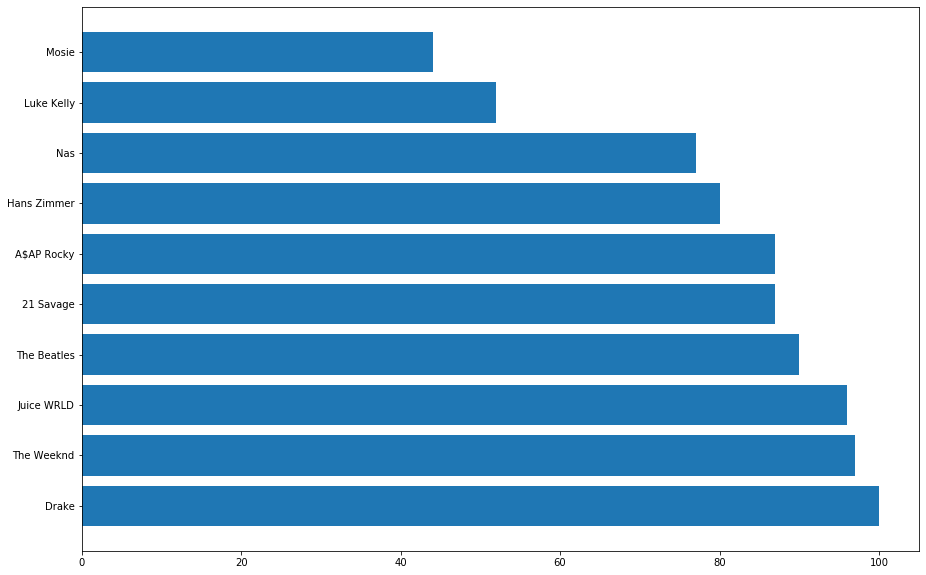

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(artists.name, artists.popularity)

# Scrape Artist Ethnicity
https://ethnicelebs.com/

In [4]:
# from bs4 import BeautifulSoup as bs4
# import requests

## Scrape all paragraphs on page

In [5]:
# def get_paragraph(artist_name):
#     headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
#     base_url = "https://ethnicelebs.com/"
    
#     # Parsed artists name
#     parse_name = artist_name.replace(" ", "-")
#     req = requests.get(base_url+parse_name, headers=headers)
#     soup = bs4(req.content, "html.parser")

#     # Find all <p> elements
#     para = str(soup.find_all('p'))

#     # Find range of string
#     string_start = para.find("Ethnicity: ") + len("Ethnicity: ")
#     string_end = para.find("</strong")
#     race = para[string_start:string_end]
    
#     if len(race) < 100:
#         return race


&nbsp;
### Add races for each artist in df
Using BeautifulSoup is really slow.

In [6]:
# # Iterate over names and scrape
# races = []
# for artist in artists.name:
#     races.append(get_paragraph(artist))

In [7]:
# # Convert to Pandas Series and add to df
# artists_races = pd.Series( v for v in races )    
# artists['race'] = artists_races
# artists.head(5)

#### Plot specific races
This plot has many specific races which gives a very messy graph. Grouping the ethnicities and removing the None values would be an improvement

In [8]:
# fig, ax = plt.subplots(figsize=(22,7))
# artists.plot.barh(x ='race', y='popularity', ax=ax)

&nbsp;
### Group ethnicities
- The artists not found from scraping are 'Unknown
- Some *assumptions* for the other races

In [9]:
# artists.race.loc[ artists.race.isnull() == True ] = 'Unknown'
# artists.race.loc[ artists.race.str.contains('English|Irish|Jewish') == True ] = 'White'
# artists.race.loc[ artists.race.str.contains('African|Black|Ethiopian') == True ] = 'Black'

#### Plot grouped races
- count() prevents popularity playing a role in the numbers
- unstack() breaks the groupby into further groups (not sure)

In [10]:
# fig, ax = plt.subplots(figsize=(15,7))

# # Group and plot
# artists.groupby('race').count().unstack().popularity.plot.bar(ax=ax)

&nbsp;
# ScraPy Efficient Scraping
BeautifulSoup was useful for starting off with scraping but it is pretty slow. ScraPy requires a little more setup but supports asynchrony making it a lot faster.

### Defining the Spider
A spider in ScraPy is a class written in Python to define the way data will be searched and parsed on the website.

In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess

class EthnicScraperSpider(scrapy.Spider):
    """Scrapes ethnic celebs website using XPath selector"""
    name = 'ethnic-scraper'
    allowed_domains = ['ethnicelebs.com'] 
    
    def __init__(self, artist='', *args, **kwargs):
        """Takes artist as an argument when called"""
        super(EthnicScraperSpider, self).__init__(*args, **kwargs)
        self.start_urls = [f'https://ethnicelebs.com/{artist}']

    def parse(self, response):
        """Get artist race"""
        next_page = response.xpath('/html/body/div/div/div/div/div/section/div[2]/article/div/div[2]/div[1]/p[4]/strong/text()').get()
        # Find word and exclude
        string_start = next_page.find("Ethnicity: ") + len("Ethnicity: ")
        race = next_page[string_start:len(next_page)]
        
        yield {
            'race': race
        } 

### Crawl for 21 Savage & Ye

In [3]:
# # Setup scraper
# process = CrawlerProcess({
#     'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
#     'FEED_FORMAT': 'json',
#     'FEED_URI': '123.json',
#     'CONCURRENT_ITEMS': 1
# # })

# crawler = process.create_crawler(EthnicScraperSpider)
# process.crawl(crawler, artist='21-savage')
# process.start()

&nbsp;
## Defining the Wikipedia Spider
After looking at some of the artists on Wikipedia, spaces in the URL seems to be filled with underscores-as opposed to dashes in ethniccelebs. This Spider will find the country of origin and the age of the artist.

In [4]:
import scrapy
from scrapy.crawler import CrawlerProcess

class WikiSpider(scrapy.Spider):
    """Scrapes Wikipedia using CSS selector"""
    name = "wiki"
    allowed_domains = ['wikipedia.org'] 
    start_urls = ['https://wikipedia.org/wiki/']

    def __init__(self, artist='', *args, **kwargs):
        """Takes artist as an argument when called"""
        # Replaces spaces with "_" for website
        artist = artist.replace(" ", "_")
        self.start_urls = [f'https://wikipedia.org/wiki/{artist}']

    def parse(self, response):
        """Get artist race"""    
        # Trim brackets and age
        age = response.xpath('/html/body/div[3]/div[3]/div[4]/div/table[1]/tbody/tr[5]/td/span[2]/text()').get()
        age = age.strip(')').lstrip(' (age ')

        country = response.xpath('/html/body/div[3]/div[3]/div[4]/div/table[1]/tbody/tr[6]/td/text()').get()
        region = response.xpath('/html/body/div[3]/div[3]/div[4]/div/table[1]/tbody/tr[6]/td/a[2]/text()').get()
    
        yield {
            'country': country,
            'region': region,
            'age': age
        }
    
# # Setup scraper
# process = CrawlerProcess({
#     'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
# })

# # Instantiate class and pass artist
# process.crawl(WikiSpider, artist='21 Savage')
# process.start()

&nbsp;
## Music Brainz API
Open music API with a Python binding allowing artists to be searched and their details returned.

In [56]:
import musicbrainzngs as brainz
from datetime import date
import datetime as dt
import math
import pandas as pd
import time

def get_brainz_artist(artist_name):
    """Pass artist name and returns age, country and gender"""
    # Set name of app
    brainz.set_useragent('lxm', version='1')

    # Get first artist in search
    artist = brainz.search_artists(artist_name, limit=1)['artist-list'][0]
    
    # Check gender key in JSON
    if 'type' in artist:    
        # Check if solo artist
        if artist['type'] == 'Person':
            gender = artist['gender']
        elif artist['type'] == 'Group':
            gender = 'mixed'
    else:
        gender = 'Unknown'
        
    # Check country key
    if 'country' in artist:
        country = artist['country']
    else:
        country = 'Unknown'
        
    district = 'unknown'
    city = 'unknown'
    # Check area key
    if 'area' in artist:
        # Check area name and type
        if 'type' in artist['area'] and 'name' in artist['area']:
            if artist['area']['type'] == 'District':
                district = artist['area']['name']
            elif artist['area']['type'] == 'City':
                city = artist['area']['name']     
    
    age = 0
    # Check life-span key
    if 'life-span' in artist:
        if 'begin' in artist['life-span']:
            born = artist['life-span']['begin']
            born = dt.datetime.strptime(born, '%Y-%m-%d').date()

            # If artist is still with us
            if artist['life-span']['ended'] == 'false':         
                # Find age as of today
                age = date.today() - born
#             else:
#                 passed = artist['life-span']['ended']
#                 passed = dt.datetime.strptime(passed, '%Y-%m-%d').date()
#                 age = passed - born

            age = math.floor(age.days/365)
            
    if age == 0:
        age = 'unknown'
        
    return {
        'artist': artist_name,
        'gender': gender, 
        'country': country, 
        'city': city,
        'district': district,
        'age': age
    }

artist_info = {}
for artist in artists.name:
#     artist_info.update(get_brainz_artist(artist))
    print(get_brainz_artist(artist))
    time.sleep(1)
    
# artist_info

{'artist': 'Drake', 'gender': 'male', 'country': 'CA', 'city': 'unknown', 'district': 'unknown', 'age': 33}


AttributeError: 'int' object has no attribute 'days'

In [ ]:
artist_info
# races = pd.DataFrame(artist_info, index=[0])
# races

In [52]:
artists.name

6                    Drake
3               Juice WRLD
1               The Weeknd
14           Billie Eilish
2              The Beatles
16                   Queen
5                21 Savage
7               A$AP Rocky
10      The Rolling Stones
15             David Bowie
12           Gus Dapperton
4              Hans Zimmer
8                      Nas
18              Neil Young
17    A Tribe Called Quest
19                    HNNY
13               Mall Grab
0               Luke Kelly
11             DJ Seinfeld
9                    Mosie
Name: name, dtype: object

### Bypass API Rate Limit
The API I'm using limits the amount of requests per minute to 60 so getting rid of this is a good idea.

In [53]:
import pprint as pp
brainz.set_useragent('hjvdksv', version='1')

artist = brainz.search_artists('Juice WRLD', limit=1)['artist-list'][0]#['area']
pp.pprint(artist)

{'alias-list': [{'alias': 'Juice WRLD 999', 'sort-name': 'Juice WRLD 999'},
                {'alias': 'Juice TheKidd', 'sort-name': 'Juice TheKidd'},
                {'alias': 'Juice WORLD', 'sort-name': 'Juice WORLD'},
                {'alias': 'Jarad Anthony Higgins',
                 'sort-name': 'Higgins, Jarad Anthony',
                 'type': 'Legal name'}],
 'area': {'id': '489ce91b-6658-3307-9877-795b68554c98',
          'life-span': {'ended': 'false'},
          'name': 'United States',
          'sort-name': 'United States',
          'type': 'Country'},
 'begin-area': {'id': '29a709d8-0320-493e-8d0c-f2c386662b7f',
                'life-span': {'ended': 'false'},
                'name': 'Chicago',
                'sort-name': 'Chicago',
                'type': 'City'},
 'country': 'US',
 'disambiguation': 'US rapper',
 'end-area': {'id': '9abe1407-8c54-4d22-933b-82c3b574716a',
              'life-span': {'ended': 'false'},
              'name': 'Oak Lawn',
              'sor

In [ ]:
#     # Get artist age 
#     if artist['life-span']['begin'] is not None:
#         # Date artist was born and parse as Date
#         born = artist['life-span']['begin']
#         born = dt.datetime.strptime(born, '%Y-%m-%d').date()
        
#         # If artist is still with us
#         if artist['life-span']['ended'] == 'false':         
#             # Find age as of today
#             age = date.today() - born
#         else:
#             passed = artist['life-span']['ended']
#             passed = dt.datetime.strptime(passed, '%Y-%m-%d').date()
#             age = passed - born
            
#         age = math.floor(age.days/365)
#     else: 
#         age = None 